# Cueing

This notebook is slightly different than the PC notebooks due to differences in the Mac operating system.

First setup the computer by following the instructions in the mac_instructions_cueing.docx file, then return to this file.

The cueing task can ellicit a number of reliable changes. A central cue indicates the location of an upcoming target onset. Here the task can be changed to be perfectly predictive, or have some level of cue validity. Task is to indicate the orientation of a spatial grating on the target, up for vertical, right for horizontal.  

ERP - Validly cued targets ellict larger ERP's than invalidly cued targets

Response ERPs - Validly cued targets are more quickly identified and better identified

Oscillations - Alpha power lateralizes after a spatial cue onset preceeding the upcoming onset of a target. Alpha power becomes smaller contraleral to the target side, and larger ipsilateral with the target. 

## Prepare the Data for Analysis

Once a suitable data set has been collected, it is now time to analyze the data and see if we can identify the cueing effects


### Load data into MNE objects

[MNE](https://martinos.org/mne/stable/index.html) is a very powerful Python library for analyzing EEG data. It provides helpful functions for performing key tasks such as filtering EEG data, rejecting artifacts, and grouping EEG data into chunks (epochs).

The first step after loading dependencies is use MNE to read the data we've collected into an MNE `Raw` object

In [1]:
from muselsl import stream, list_muses, view, record
from multiprocessing import Process
from mne import Epochs, find_events, concatenate_raws
from mne.time_frequency import tfr_morlet
import numpy as np
from time import time, strftime, gmtime
import os
from stimulus_presentation import cueing
from utils import utils
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
import matplotlib.patches as patches


pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


101
Creating RawArray with float64 data, n_channels=5, n_times=61284
    Range : 0 ... 61283 =      0.000 ...   239.387 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=61284
    Range : 0 ... 61283 =      0.000 ...   239.387 secs
Ready.
Setting up band-pass filter from 1 - 30 Hz
Setting up band-pass filter from 1 - 30 Hz
122 events found
Event IDs: [ 1  2 11 12 21 22]
Trials Remaining: 10.
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
102
Creating RawArray with float64 data, n_channels=5, n_times=61296
    Range : 0 ... 61295 =      0.000 ...   239.434 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=61296
    Range : 0 ... 61295 =      0.000 ...   239.434 secs
Ready.
Setting up band-pass filter from 1 - 30 Hz
Setting up band-pass filter from 1 - 30 Hz
92 events found
Event IDs: [ 1  2 11 12 21 22]
Trials Remaining: 40.
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
1

Ready.
Setting up band-pass filter from 1 - 30 Hz
Setting up band-pass filter from 1 - 30 Hz
181 events found
Event IDs: [ 1  2 11 12 21 22]
Trials Remaining: 70.
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
209
Creating RawArray with float64 data, n_channels=5, n_times=61296
    Range : 0 ... 61295 =      0.000 ...   239.434 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=61296
    Range : 0 ... 61295 =      0.000 ...   239.434 secs
Ready.
Setting up band-pass filter from 1 - 30 Hz
Setting up band-pass filter from 1 - 30 Hz
118 events found
Event IDs: [ 1  2 11 12 21 22]
Trials Remaining: 5.
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
210
Creating RawArray with float64 data, n_channels=5, n_times=61284
    Range : 0 ... 61283 =      0.000 ...   239.387 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=61296
    Range : 0 ... 61295 =      0.000 ...   239.434 secs
R

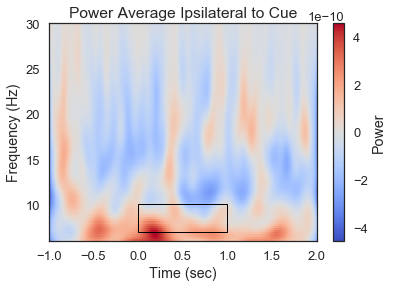

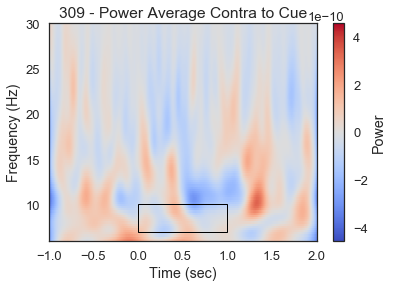

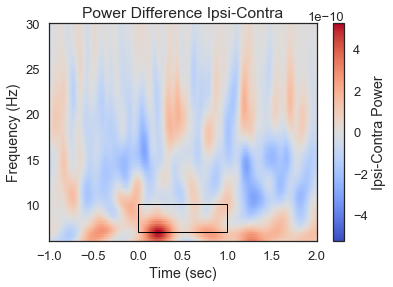

In [2]:
subs = [101, 102, 103, 104, 105, 106, 108, 109, 110, 111, 112,
        202, 203, 204, 205, 207, 208, 209, 210, 211, 
        301, 302, 303, 304, 305, 306, 307, 308, 309]

diff_out = []
Ipsi_out = []
Contra_out = []
Ipsi_spectra_out = []
Contra_spectra_out = []
diff_spectra_out = []
ERSP_diff_out = []
ERSP_Ipsi_out = []
ERSP_Contra_out = []

frequencies =  np.linspace(6, 30, 100, endpoint=True)
wave_cycles = 6

# time frequency window for analysis
f_low = 7 # Hz
f_high = 10
f_diff = f_high-f_low
 
t_low = 0 # s
t_high = 1
t_diff = t_high-t_low

bad_subs= [6, 7, 13, 26]
really_bad_subs = [11, 12, 19]
sub_count = 0    
    
    
    
for sub in subs:
    print(sub)
    
    sub_count += 1

    
    if (sub_count in really_bad_subs):
        rej_thresh_uV = 90
    elif (sub_count in bad_subs):
        rej_thresh_uV = 90
    else:
        rej_thresh_uV = 90

    rej_thresh = rej_thresh_uV*1e-6
    

    
    # Load both sessions
    raw = utils.load_data('visual/cueing', sfreq=256., 
                          subject_nb=sub, session_nb=1)
    raw.append(    utils.load_data('visual/cueing', sfreq=256., 
                          subject_nb=sub, session_nb=2)           )

    # Filter Raw Data
    raw.filter(1,30, method='iir')

    #Select Events
    events = find_events(raw)
    event_id = {'LeftCue': 1, 'RightCue': 2}
    epochs = Epochs(raw, events=events, event_id=event_id, 
                    tmin=-1, tmax=2, baseline=(-1, 0), 
                    reject={'eeg':rej_thresh}, preload=True,
                    verbose=False, picks=[0, 3])
    print('Trials Remaining: ' + str(len(epochs.events)) + '.')

    # Compute morlet wavelet

    # Left Cue
    tfr, itc = tfr_morlet(epochs['LeftCue'], freqs=frequencies, 
                          n_cycles=wave_cycles, return_itc=True)
    tfr = tfr.apply_baseline([-1,-.5],mode='mean')
    #tfr.plot(picks=[0], mode='logratio', 
    #         title='TP9 - Ipsi');
    #tfr.plot(picks=[3], mode='logratio', 
    #         title='TP10 - Contra');
    power_Ipsi_TP9 = tfr.data[0,:,:]
    power_Contra_TP10 = tfr.data[1,:,:]

    # Right Cue
    tfr, itc = tfr_morlet(epochs['RightCue'], freqs=frequencies, 
                          n_cycles=wave_cycles, return_itc=True)
    tfr = tfr.apply_baseline([-1,-.5],mode='mean')
    #tfr.plot(picks=[0], mode='logratio', 
    #         title='TP9 - Contra');
    #tfr.plot(picks=[3], mode='logratio', 
    #         title='TP10 - Ipsi');
    power_Contra_TP9 = tfr.data[0,:,:]
    power_Ipsi_TP10 = tfr.data[1,:,:]

    # Plot Differences
    %matplotlib inline
    times = epochs.times
    power_Avg_Ipsi =   (power_Ipsi_TP9+power_Ipsi_TP10)/2;
    power_Avg_Contra = (power_Contra_TP9+power_Contra_TP10)/2;
    power_Avg_Diff = power_Avg_Ipsi-power_Avg_Contra;


    #find max to make color range
    plot_max = np.max([np.max(np.abs(power_Avg_Ipsi)), np.max(np.abs(power_Avg_Contra))])
    plot_diff_max = np.max(np.abs(power_Avg_Diff))

   
    
    #Ipsi
    fig, ax = plt.subplots(1)
    im = plt.imshow(power_Avg_Ipsi,
               extent=[times[0], times[-1], frequencies[0], frequencies[-1]],
               aspect='auto', origin='lower', cmap='coolwarm', vmin=-plot_max, vmax=plot_max)
    plt.xlabel('Time (sec)')
    plt.ylabel('Frequency (Hz)')
    plt.title('Power Average Ipsilateral to Cue')
    cb = fig.colorbar(im)
    cb.set_label('Power')
    # Create a Rectangle patch
    rect = patches.Rectangle((t_low,f_low),t_diff,f_diff,linewidth=1,edgecolor='k',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)

    #TP10
    fig, ax = plt.subplots(1)
    im = plt.imshow(power_Avg_Contra,
               extent=[times[0], times[-1], frequencies[0], frequencies[-1]],
               aspect='auto', origin='lower', cmap='coolwarm', vmin=-plot_max, vmax=plot_max)
    plt.xlabel('Time (sec)')
    plt.ylabel('Frequency (Hz)')
    plt.title(str(sub) + ' - Power Average Contra to Cue')
    cb = fig.colorbar(im)
    cb.set_label('Power')
    # Create a Rectangle patch
    rect = patches.Rectangle((t_low,f_low),t_diff,f_diff,linewidth=1,edgecolor='k',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)

    #difference between conditions
    fig, ax = plt.subplots(1)
    im = plt.imshow(power_Avg_Diff,
               extent=[times[0], times[-1], frequencies[0], frequencies[-1]],
               aspect='auto', origin='lower', cmap='coolwarm', vmin=-plot_diff_max, vmax=plot_diff_max)
    plt.xlabel('Time (sec)')
    plt.ylabel('Frequency (Hz)')
    plt.title('Power Difference Ipsi-Contra')
    cb = fig.colorbar(im)
    cb.set_label('Ipsi-Contra Power')
    # Create a Rectangle patch
    rect = patches.Rectangle((t_low,f_low),t_diff,f_diff,linewidth=1,edgecolor='k',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
     
        
   
        
    #output data into array
    Ipsi_out.append(np.mean(power_Avg_Ipsi[np.argmax(frequencies>f_low):np.argmax(frequencies>f_high)-1,
                            np.argmax(times>t_low):np.argmax(times>t_high)-1 ]))            
    Ipsi_spectra_out.append(np.mean(power_Avg_Ipsi[:,np.argmax(times>t_low):np.argmax(times>t_high)-1 ],1))
    
    
    Contra_out.append(np.mean(power_Avg_Contra[np.argmax(frequencies>f_low):np.argmax(frequencies>f_high)-1,
                            np.argmax(times>t_low):np.argmax(times>t_high)-1 ]))
    Contra_spectra_out.append(np.mean(power_Avg_Contra[:,np.argmax(times>t_low):np.argmax(times>t_high)-1 ],1))
    
    
    diff_out.append(np.mean(power_Avg_Diff[np.argmax(frequencies>f_low):np.argmax(frequencies>f_high)-1,
                            np.argmax(times>t_low):np.argmax(times>t_high)-1 ]))
    diff_spectra_out.append(np.mean(power_Avg_Diff[:,np.argmax(times>t_low):np.argmax(times>t_high)-1 ],1))
    
    
    ERSP_diff_out.append(power_Avg_Diff)
    ERSP_Ipsi_out.append(power_Avg_Ipsi)
    ERSP_Contra_out.append(power_Avg_Contra)


(29, 100, 769)
(29, 100)
[-1.8633016529355464e-10, -5.1944926980416581e-11, 3.9657173668456859e-11, -1.7945284025174142e-11, 1.5395426956926024e-10, nan, nan, 1.4375205304704689e-10, 6.1564138012933193e-12, -3.4542289627376952e-11, nan, 1.4040022690241438e-10, 4.5250575579733792e-11, 8.1334144217173148e-11, 1.7562617842729126e-12, 3.4989854712143396e-11, -7.3584488884127253e-11, -2.0667398674718817e-11, 5.8338322314763061e-11, -1.1353507280272532e-10, 2.0578545669354458e-10, 8.1361290782567698e-11, 2.2311245651295559e-09, 4.4172040165036077e-13, 1.5824220701839024e-10, nan, 2.9726944442082986e-11, -2.7053453190038884e-11, 1.003226256634192e-10]


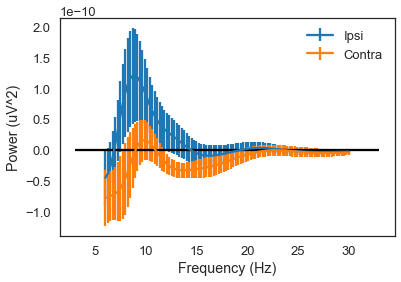

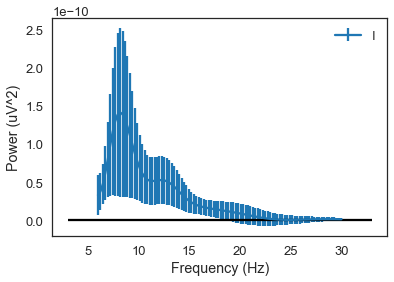

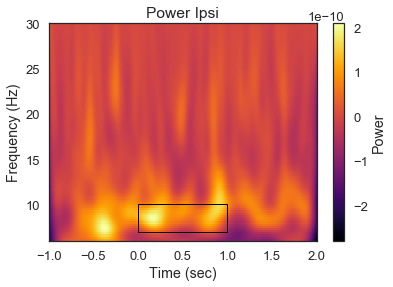

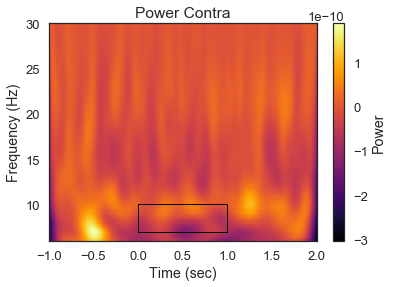

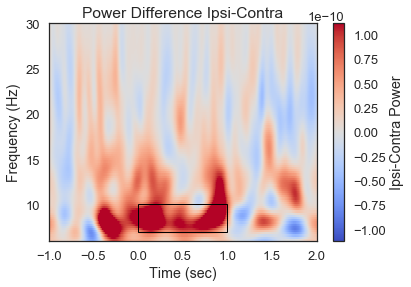

In [3]:
    print(np.shape(ERSP_diff_out))
    print(np.shape(Contra_spectra_out))
  
    print(diff_out)
    
    
    GrandAvg_diff = np.nanmean(ERSP_diff_out,0)
    GrandAvg_Ipsi = np.nanmean(ERSP_Ipsi_out,0)
    GrandAvg_Contra = np.nanmean(ERSP_Contra_out,0)
    
    GrandAvg_spec_Ipsi = np.nanmean(Ipsi_spectra_out,0)
    GrandAvg_spec_Contra = np.nanmean(Contra_spectra_out,0)
    GrandAvg_spec_diff = np.nanmean(diff_spectra_out,0)
    
    num_good = len(diff_out) - sum(np.isnan(diff_out))   
    GrandAvg_spec_Ipsi_ste = np.nanstd(Ipsi_spectra_out,0)/np.sqrt(num_good)
    GrandAvg_spec_Contra_ste = np.nanstd(Contra_spectra_out,0)/np.sqrt(num_good)
    GrandAvg_spec_diff_ste = np.nanstd(diff_spectra_out,0)/np.sqrt(num_good)
   
    #Spectra error bars
    fig, ax = plt.subplots(1)
    plt.errorbar(frequencies,GrandAvg_spec_Ipsi,yerr=GrandAvg_spec_Ipsi_ste)
    plt.errorbar(frequencies,GrandAvg_spec_Contra,yerr=GrandAvg_spec_Contra_ste)

    plt.legend(('Ipsi','Contra'))
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power (uV^2)')   
    plt.hlines(0,3,33)
    
    #Spectra Diff error bars
    fig, ax = plt.subplots(1)
    plt.errorbar(frequencies,GrandAvg_spec_diff,yerr=GrandAvg_spec_diff_ste)

    plt.legend('Ipsi-Contra')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power (uV^2)')   
    plt.hlines(0,3,33)

    ##Spectra
    #fig, ax = plt.subplots(1)
    #plt.plot(frequencies,GrandAvg_spec_Ipsi,
    #         frequencies,GrandAvg_spec_Contra,
    #         frequencies,GrandAvg_spec_diff)
    #plt.hlines(0,3,33)
    #plt.legend(('Ipsi','Contra','Diff'))
    #plt.xlabel('Frequency (Hz)')
    #plt.ylabel('Power (uV^2)')
      
    
    #Grand Average Ipsi
    fig, ax = plt.subplots(1)
    im = plt.imshow(GrandAvg_Ipsi,
               extent=[times[0], times[-1], frequencies[0], frequencies[-1]],
               aspect='auto', origin='lower', cmap='inferno')
    plt.xlabel('Time (sec)')
    plt.ylabel('Frequency (Hz)')
    plt.title('Power Ipsi')
    cb = fig.colorbar(im)
    cb.set_label('Power')
    # Create a Rectangle patch
    rect = patches.Rectangle((t_low,f_low),t_diff,f_diff,linewidth=1,edgecolor='k',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    
    #Grand Average Contra
    fig, ax = plt.subplots(1)
    im = plt.imshow(GrandAvg_Contra,
               extent=[times[0], times[-1], frequencies[0], frequencies[-1]],
               aspect='auto', origin='lower', cmap='inferno')
    plt.xlabel('Time (sec)')
    plt.ylabel('Frequency (Hz)')
    plt.title('Power Contra')
    cb = fig.colorbar(im)
    cb.set_label('Power')
    # Create a Rectangle patch
    rect = patches.Rectangle((t_low,f_low),t_diff,f_diff,linewidth=1,edgecolor='k',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    
    #Grand Average Ipsi-Contra Difference
    plot_max_diff = np.max(np.abs(GrandAvg_diff))

    fig, ax = plt.subplots(1)
    im = plt.imshow(GrandAvg_diff,
               extent=[times[0], times[-1], frequencies[0], frequencies[-1]],
               aspect='auto', origin='lower', cmap='coolwarm', vmin=-plot_max_diff/2, vmax=plot_max_diff/2)
    plt.xlabel('Time (sec)')
    plt.ylabel('Frequency (Hz)')
    plt.title('Power Difference Ipsi-Contra')
    cb = fig.colorbar(im)
    cb.set_label('Ipsi-Contra Power')
    # Create a Rectangle patch
    rect = patches.Rectangle((t_low,f_low),t_diff,f_diff,linewidth=1,edgecolor='k',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    
    

In [4]:
import scipy
num_good = len(diff_out) - sum(np.isnan(diff_out))

[tstat, pval] = scipy.stats.ttest_ind(diff_out,np.zeros(len(diff_out)),nan_policy='omit')
print('t(' + str(num_good-1) + ') = ' + str(round(tstat,3)))
print('p = ' + str(round(pval,3)))

t(24) = 1.434
p = 0.157
